<a href="https://colab.research.google.com/github/X-sena-X/DataScience_Projects-/blob/main/LipSyncNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bi

In [ ]:
!pip install tensorflow opencv-python matplotlib imageio gdown



```
# This is formatted as code
```

# Importing libraries

here we import the packages needed

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
'''
Here we make the GPU not to exponentially increase
'''
physical_devices = tf.config.list_physical_devices("GPU")

try:
  tf.config.experimental.set_memory_growth(physical_devices[0],True)

except:
  pass

# Build Data Loading function

we have to load the video and the annotation of the speech matching the correct time span.

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=True)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=a0fa2425-6cac-49b8-af33-786d8d3c2380
To: /content/data.zip
100%|██████████| 423M/423M [00:06<00:00, 69.4MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

Here we load the video and get the lips movement and position marked

In [ ]:
def load_video(path:str)-> List[float]:

  cap = cv2.VideoCapture(path)
  frames = []

  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret,frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236,80:220,:])
  cap.release()

  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames,tf.float32))
  return tf.cast((frames - mean),tf.float32 )/ std

vocabulary for the detected annotation

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!1234567890 "]

Connectionist Temporal Classification (CTC) loss

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', ' '] (size =41)


In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path:str):
  path = bytes.decode(path.numpy())
  file_name = path.split("/")[-1].split(".")[0]
  video_path = os.path.join('data','s1',f"{file_name}.mpg")
  alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path).l

  return frames, alignments

In [ ]:
test_path="./data/s1/bbaf2n.mp9"

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('UTF-8').split('/')[-1].split('.')[0]

'bbaf2n'

In [ ]:
frames_1,alignments_1 = load_data(tf.convert_to_tensor(test_path))

In [ ]:
frames_1

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4616871 ],
         [1.4616871 ],
         [1.4991663 ],
         ...,
         [0.3373124 ],
         [0.3373124 ],
         [0.3373124 ]],

        ...,

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.11243746],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.07495831],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.07495831],
         [0.07495831],
         [0.03747915]]],


  

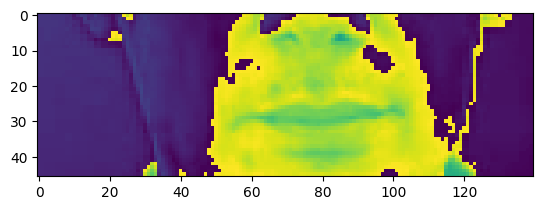

In [ ]:
plt.imshow(frames_1[1])

In [ ]:
alignments_1

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 40,  2, 12, 21,  5, 40,  1, 20, 40,  6, 40, 20, 23, 15,
       40, 14, 15, 23])>

In [ ]:
print([bytes.decode(x) for x in num_to_char(alignments_1.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'f', ' ', 't', 'w', 'o', ' ', 'n', 'o', 'w']


In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments_1.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

raw string when using tensorflow datapipe line it is recommended to use tf.py_function()

In [ ]:
def mappable_function(path:str) -> List[str]:
  result = tf.py_function(load_data,[path],(tf.float32,tf.int64))
  return result

# Data pipeline

here the tensorflow takes a random set of alignment and mpg files and train your model

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')     # to make a list of file name using tensorflow
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

data.padded_batch(2, padded_shapes=([75,None,None,None],[40])) to ensure we have  75 frames and image of any size and then 40 tokens of alignments

In [ ]:
frames,alignment = data.as_numpy_iterator().next()

In [ ]:
test = data.as_numpy_iterator()

In [ ]:
val = test.next()

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay red at e two now'>

In [ ]:
#imageio.mimsave('./animation.gif',val[0][1],fps=10)

# NN design

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][1].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))    #75 inputs into LSTM input

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 9s 9s/step


In [ ]:
yhat[1].shape

(75, 42)

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'jjjjjjjjjjjjjjjjjj88888888888888jjjjjjjjjjjjjjjjjjjjjjjjjjjjjj2222'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 42)

# Train and adding loss Function

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss= CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'),monitor="loss", save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(data)

training the model with data

In [ ]:
model.fit(data,epochs=100, callbacks=[checkpoint_callback, schedule_callback,example_callback])

Epoch 1/100
1/1 [==============================] - 2s 2s/step
Original: bin green with b six please
Prediction: la e e e e en
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green by u three soon
Prediction: la e e e e e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 515s 974ms/step - loss: 83.9705 - lr: 1.0000e-04
Epoch 2/100
1/1 [==============================] - 0s 204ms/step
Original: set red by i zero please
Prediction: la e e e e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red at k seven soon
Prediction: la e e e e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 473s 945ms/step - loss: 69.5509 - lr: 1.0000e-04
Epoch 3/100
1/1 [======================